## <center><u>Deep Learning and Neural Networks: Final Project</u></center>

#### <center>This notebooks contains the Finetuning of Pegasus-Large Model</center>

In [ ]:
# Installing the BLURR library and Bert-Score package

!pip install ohmeow-blurr -q
!pip install bert-score -q
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *
import pickle

/usr/local/lib/python3.9/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [ ]:
from datasets import load_dataset

# Load the dataset from Hugging Face
dataset = load_dataset('ccdv/pubmed-summarization')

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset pubmed-summarization downloaded and prepared to /root/.cache/huggingface/datasets/ccdv___pubmed-summarization/section/1.0.0/f765ec606c790e8c5694b226814a13f1974ba4ea98280989edaffb152ded5e2b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Dataframe for Train Dataset
train_data = pd.DataFrame(dataset['train'])

In [ ]:
# Replacing Newline Character
train_data['article'] = train_data['article'].apply(lambda x: x.replace('\n',''))

In [ ]:
# Fine-tuning on first 1000 records
train_data = train_data.head(1000)
train_data.shape

(1000, 2)

In [ ]:
# Import the pretrained model (Pegausus Large)
from transformers import  PegasusForConditionalGeneration
pretrained_model_name = "google/pegasus-large"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, 
                                                                  model_cls=PegasusForConditionalGeneration)

In [ ]:
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('pegasus',
 transformers.models.pegasus.configuration_pegasus.PegasusConfig,
 transformers.models.pegasus.tokenization_pegasus_fast.PegasusTokenizerFast,
 transformers.models.pegasus.modeling_pegasus.PegasusForConditionalGeneration)

In [ ]:
# Initialize Summarization Preprocessor

preprocessor = SummarizationPreprocessor(
    hf_tokenizer,
    id_attr="id",
    text_attr="article",
    target_text_attr="abstract",
    max_input_tok_length=1024,
    max_target_tok_length=256,
    min_summary_char_length=30
)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Calling preprocessor to process the data
proc_df = preprocessor.process_df(train_data)

In [ ]:
# Extracting parameters to be passed to the tokenizer
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task="summarization")

# Initializing Seq2Seq Tokenizer
batch_tokenize_transform = Seq2SeqBatchTokenizeTransform(
  hf_arch, hf_config, hf_tokenizer, hf_model, text_gen_kwargs=text_gen_kwargs
)

blocks = (Seq2SeqTextBlock(batch_tokenize_tfm = batch_tokenize_transform), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader( "proc_article"), get_y=ColReader("proc_abstract" ),
splitter=RandomSplitter())

In [ ]:
# Initializing dataloader with batch size of 2
dls = dblock.dataloaders(proc_df, bs=2)

In [ ]:
# Metrics to be calculated for summarization task
summarization_metrics = {
  "rouge": {
      "compute_kwargs": {"rouge_types" : ["rouge1", "rouge2", "rougeL"],
          "use_stemmer": True
      },
      "returns": ["rouge1", "rouge2", "rougeL"],
  },
  "bertscore": {"compute_kwargs": {"lang" : "en"},
  "returns": ["precision", "recall", "f1"]
  },
  "bleu": {"returns": "bleu"},
  "meteor" : {"returns": "meteor"},
  "sacrebleu": {"returns" : "score"}
}

In [ ]:
# Initialize Model
model = BaseModelWrapper(hf_model) 

# Initialize learner callback
learn_cbs = [BaseModelCallback]

# Callback for calculation of metrics
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=summarization_metrics, calc_every="epoch")]

# Initialize Fast.AI Learner
learn = Learner(
  dls,
  model, 
  opt_func=partial(Adam),
  loss_func=PreCalculatedCrossEntropyLoss(),
  cbs=learn_cbs,
  splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

# Setting precision to 16-bit floating
learn = learn.to_fp16()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


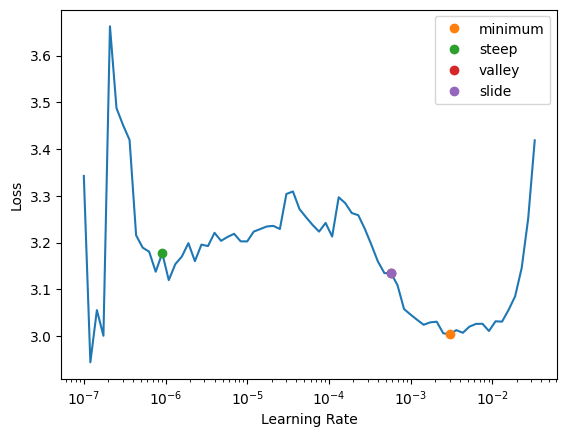

In [ ]:
# Finding Optimal Learning Rate
res = learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
# Importing nltk modules
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Optimizing the train run

import pprint
import traceback

import gc

pp = pprint.PrettyPrinter(indent=4)
torch.cuda.ipc_collect()
torch.cuda.empty_cache()
gc.collect()

for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            del obj
            torch.cuda.empty_cache()
    except Exception:
      pass

In [ ]:
# Running Fine-tuning
db=learn.fit_one_cycle(10,lr_max=res.valley, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,bleu,meteor,sacrebleu,time
0,2.614830,2.323025,0.299602,0.092945,0.191521,0.800929,0.801133,0.800806,0.119661,0.219586,8.656383,13:42
1,2.514609,2.344362,0.318056,0.105607,0.206998,0.822207,0.828733,0.825231,0.136259,0.236301,10.167708,13:28
2,nan,2.357735,0.332587,0.111715,0.205386,0.822769,0.834903,0.828568,0.137318,0.251044,10.321654,13:31
3,nan,2.389551,0.361313,0.134279,0.225891,0.830956,0.842286,0.836171,0.159450,0.264392,12.763770,13:28
4,nan,2.470458,0.382399,0.139448,0.232531,0.836771,0.845858,0.841120,0.167330,0.285426,12.862054,13:31
5,nan,2.613964,0.378794,0.139204,0.226435,0.837299,0.846460,0.841667,0.165017,0.285585,12.805346,13:44
6,nan,2.709525,0.386593,0.141299,0.233633,0.842827,0.847736,0.845122,0.175010,0.286609,13.501794,13:26
7,nan,2.909751,0.391598,0.143798,0.233892,0.843266,0.849570,0.846242,0.174141,0.292671,13.329426,13:27
8,nan,3.033891,0.392712,0.145349,0.233971,0.843400,0.849390,0.846210,0.175892,0.293290,13.471189,13:27
9,nan,3.094626,0.390060,0.145048,0.233071,0.843470,0.849577,0.846327,0.175383,0.289647,13.450867,13:30


In [ ]:
# Printing results obtained after fine-tuning
res = learn.show_results(learner=learn)

In [ ]:
# Saving the model in pickle format
learn.metrics = None
learn = learn.to_fp32()
learn.export(fname="pegasus_summary_export.pkl")

In [ ]:
test_article = train_data.iloc[10]
test_article = test_article.article

In [ ]:
# Loading Model to perform inferencing
infer = load_learner(fname="pegasus_summary_export.pkl")
res = infer.blurr_summarize(test_article)

In [ ]:
# Summary obtained
res[0]['summary_texts']

"objectiveearly detection of alzheimer 's disease ( ad ) is urgently needed given the large economic and societal burden the illness inflicts on individuals and the healthcare system . we sought to develop a simple blood test that could identify cognitively normal older adults at risk of developing ad early.research design and methodseighty - two cognitively normal older adults ( average age 71 years ) with no history of alzheimer 's disease were randomly assigned to one of three groups ( a142 , a142 + placebo , or a142 + placebo ) : a142 + placebo , a142 + placebo , or no history of alzheimer 's disease ( control group ) . blood was drawn from the subjects at baseline and every 12 weeks for cerebrospinal fluid ( csf ) measurements . serum levels of phosphorylated tau and pittsburgh compound b ( pib ) were measured at baseline and every 12 weeks for the next two years.resultsthe a142 and pib groups showed significantly higher baseline serum levels of phosphorylated tau and pittsburgh c

In [ ]:
# Ground Truth
train_data.iloc[10].abstract

'we examined the usefulness of brief neuropsychological tests and serum a as a predictive test for detecting mci / ad in older adults . \n serum a levels were measured from 208 subjects who were cognitively normal at enrollment and blood draw . \n twenty - eight of the subjects subsequently developed mci ( n = 18 ) or ad ( n = 10 ) over the follow - up period . \n baseline measures of global cognition , memory , language fluency , and serum a142 and the ratio of serum a142/a140 were significant predictors for future mci / ad using cox regression with demographic variables , apoe 4 , vascular risk factors , and specific medication as covariates . an optimal sensitivity of 85.2% and specificity of 86.5% for predicting mci / ad was achieved using roc analyses . \n brief neuropsychological tests and measurements of a142 obtained via blood warrants further study as a practical and cost effective method for wide - scale screening for identifying older adults who may be at - risk for patholog